# Exploring the dataset

In [1]:
import pandas as pd

In [2]:
path2csv = "./data/train_labels.csv"
labels_df = pd.read_csv(path2csv)
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
print(labels_df['label'].value_counts())

0    130908
1     89117
Name: label, dtype: int64


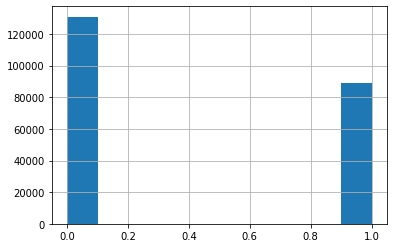

In [4]:
%matplotlib inline
labels_df['label'].hist();

In [5]:
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import numpy as np
import os
%matplotlib inline

In [6]:
# get ids for malignant images
malignantIds = labels_df.loc[labels_df['label']==1]['id'].values

In [7]:
# data is stored here
path2train = "./data/train/"

In [8]:
# show images in grayscale, if you want color change it to True
color = False

In [9]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows, ncols = 3, 3

<Figure size 720x720 with 0 Axes>

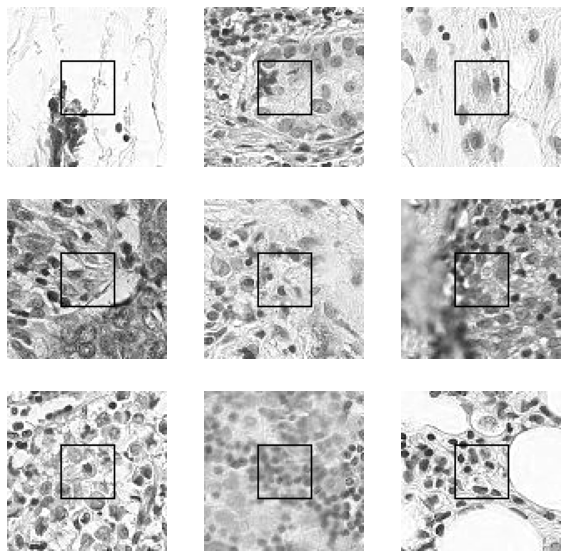

In [10]:
for i, id_ in enumerate(malignantIds[:nrows*ncols]):
    full_filenames = os.path.join(path2train, id_+'.tif')
    
    # load image
    img = Image.open(full_filenames)
    
    # draw a 32*32 rectangle
    draw = ImageDraw.Draw(img)
    draw.rectangle(((32,32), (64, 64)), outline="green")
    plt.subplot(nrows, ncols, i+1)
    if color is True:
        plt.imshow(np.array(img))
    else:
        plt.imshow(np.array(img)[:,:,0], cmap="gray")
    plt.axis('off')
    
    

In [11]:
print("image shape : ", np.array(img).shape)
print("pixel values range from %s to %s" %(np.min(img),
                                               np.max(img)))

image shape :  (96, 96, 3)
pixel values range from 0 to 255


# Creating a custom dataset

In [12]:
from PIL import Image
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
import os

In [13]:
# fix torch random seed
torch.manual_seed(0)

In [14]:
class histoCancerDataset(Dataset):
    def __init__(self, data_dir, transform, data_type="train"):
        # path to images
        path2data = os.path.join(data_dir, data_type)
        
        # get a list of images
        filenames = os.listdir(path2data)
        
        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in 
                               filenames]
        # labels are in a csv file named train_labels.csv
        csv_filename = data_type+"_labels.csv"
        path2csvLabels = os.path.join(data_dir, csv_filename)
        labels_df = pd.read_csv(path2csvLabels)
        
        # set data frame index to id
        labels_df.set_index("id", inplace=True)
        
        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for
        filename in filenames]
        
        self.transform = transform
        
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx]) # PIL image
        image = self.transform(image)
        return image, self.labels[idx]
        

In [15]:
import torchvision.transforms as transforms

In [16]:
data_transformer = transforms.Compose([transforms.ToTensor()])

In [17]:
data_dir = "./data/"
histo_dataset = histoCancerDataset(data_dir, data_transformer, "train")
print(len(histo_dataset))

220025


In [18]:
# Load an image
img, label = histo_dataset[9]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 96, 96]) tensor(0.) tensor(1.)


# Splitting the dataset

In [19]:
from torch.utils.data import random_split

len_histo = len(histo_dataset)
len_train = int(0.8*len_histo)
len_val = len_histo-len_train

train_ds, val_ds = random_split(histo_dataset, [len_train, len_val])

print("train dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))


train dataset length: 176020
validation dataset length: 44005


In [20]:
for x, y in train_ds:
    print(x.shape, y)
    break

torch.Size([3, 96, 96]) 0


In [21]:
for x, y in val_ds:
    print(x.shape, y)
    break

torch.Size([3, 96, 96]) 1


In [22]:
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

In [23]:
def show(img, y, color=False):
    # convert tensor to numpy array
    npimg = img.numpy()
    # convert to H*W*C shape
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    if color==False:
        npimg_tr = npimg_tr[:,:,0]
        plt.imshow(npimg_tr, interpolation='nearest', cmap='gray')
    else:
        # display images
        plt.imshow(npimg_tr, interpolation='nearest')
        
    plt.title("label: "+str(y))

image indices: [ 43567 173685 117952 152315]
torch.Size([3, 100, 394])


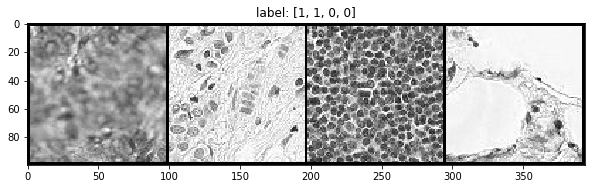

In [24]:
# create a grid of sample images
grid_size = 4
rnd_inds = np.random.randint(0, len(train_ds), grid_size)
print("image indices:", rnd_inds)

x_grid_train = [train_ds[i][0] for i in rnd_inds]
y_grid_train = [train_ds[i][1] for i in rnd_inds]

x_grid_train = utils.make_grid(x_grid_train, nrow=4, padding=2)
print(x_grid_train.shape)

plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_train, y_grid_train)

image indices: [30403 32103 41993 20757]
torch.Size([3, 100, 394])


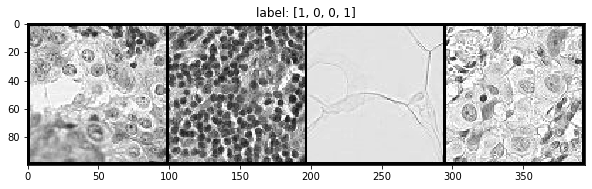

In [25]:
# show a few samples from val_ds
grid_size = 4
rnd_inds = np.random.randint(0, len(val_ds), grid_size)
print("image indices:", rnd_inds)

x_grid_val = [val_ds[i][0] for i in range(grid_size)]
y_grid_val = [val_ds[i][1] for i in range(grid_size)]

x_grid_val = utils.make_grid(x_grid_val, nrow=4, padding=2)
print(x_grid_val.shape)
show(x_grid_val, y_grid_val)

# Transforming the data

In [26]:
train_transformer = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomVerticalFlip(p=0.5),
                                       transforms.RandomRotation(45),
                                       transforms.RandomResizedCrop(96, scale=(0.8, 1.0),
                                        ratio=(1.0, 1.0)), transforms.ToTensor()])

In [27]:
val_transformer = transforms.Compose([transforms.ToTensor()])

In [28]:
# overwrite the transform functions
train_ds.transform = train_transformer
val_ds.transform = val_transformer

# Creating dataloaders

In [29]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)


In [30]:
# extract a batch from training data
for x,y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 96, 96])
torch.Size([32])


In [31]:
for x, y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 3, 96, 96])
torch.Size([64])


# Building the classification model

In [32]:
# get labels for validation dataset
y_val = [y for _,y in val_ds]

In [33]:
def accuracy(labels, out):
    return np.sum(out==labels)/float(len(labels))

# accuracy all zero predictions
acc_all_zeros = accuracy(y_val, np.zeros_like(y_val))
print("accuracy all zero prediction: %.2f" %acc_all_zeros)

accuracy all zero prediction: 0.59


In [34]:
# accuracy all ones predictions
acc_all_ones = accuracy(y_val, np.ones_like(y_val))

print("accuracy all one prediction: %.2f" %acc_all_ones)

accuracy all one prediction: 0.41


In [35]:
# accuracy random predictions
acc_random = accuracy(y_val, np.random.randint(2, size=len(y_val)))

print("accuracy random prediction: %.2f" %acc_random)

accuracy random prediction: 0.50


In [36]:
# calculate output size of a CNN layer
import torch.nn as nn
import numpy as np

In [37]:
def findConv2dOutShape(H_in, W_in, conv, pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation
    
    H_out = np.floor((H_in+2*padding[0]-
                     dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out = np.floor(W_in+2*padding[1]-
                     dilation[1]*(kernel_size[1]-1)/stride[1]+1)
    
    if pool:
        H_out/=pool
        W_out/=pool
    return int(H_out), int(W_out)


In [38]:
# example
conv1 = nn.Conv2d(3, 8, kernel_size=3)
h, w = findConv2dOutShape(96, 96, conv1)
print(h, w)

47 47


In [39]:
# implement the CNN model
import torch.nn as nn
import torch.nn.functional as F

In [40]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
        C_in, H_in, W_in = params["input_shape"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
        h, w = findConv2dOutShape(H_in, W_in, self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kerner_size=3)
        h, w = findConv2dOutShape(h, w, self.conv2)
        
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h, w = findConv2dOutShape(h, w, self.conv4)
        #compute the flatten size
        self.num_flatten = h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

In [ ]:
def forward(self, x):
    x = F.relu
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, self.num_flatten)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, self.dropout_rate, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)